In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import dask.dataframe as dd
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import shapely

In [3]:
plt.rcParams['savefig.dpi'] = 150

In [4]:
import dask.distributed
client = dask.distributed.Client('localhost:8786')
client.restart()

<Client: scheduler='tcp://localhost:8786' processes=4 cores=4>

In [5]:
taxi = dd.read_parquet('/bigdata/all_trips.parquet', columns=[
        'pickup_datetime', 
        'pickup_taxizone_id',
        'pickup_latitude',
        'pickup_longitude',
#         'dropoff_datetime', 
#         'dropoff_taxizone_id', 
#         'dropoff_datetime', 
#         'trip_type', 
#         'trip_distance'
    ])

In [6]:
taxi.columns

Index(['pickup_datetime', 'pickup_taxizone_id', 'pickup_latitude',
       'pickup_longitude'],
      dtype='object')

In [7]:
taxi.head()

pickup_datetime  pickup_taxizone_id  pickup_latitude  pickup_longitude
0 2014-04-01 00:11:00                 NaN          40.7690          -73.9549
1 2014-04-01 00:17:00                 NaN          40.7267          -74.0345
2 2014-04-01 00:21:00                 NaN          40.7316          -73.9873
3 2014-04-01 00:28:00                 NaN          40.7588          -73.9776
4 2014-04-01 00:33:00                 NaN          40.7594          -73.9722

In [8]:
mask = (taxi['pickup_datetime'] > '2015-07-01') & (taxi['pickup_datetime'] < '2015-09-01')

In [9]:
taxi2 = (taxi[mask]).set_index('pickup_datetime', npartitions=16).reset_index()
taxi2.to_parquet('/data/trips_2015-JulyAug.parquet', compression='SNAPPY', has_nulls=True, object_encoding='json')

In [5]:
taxi2 = dd.read_parquet('/data/trips_2015-JulyAug.parquet')

In [6]:
taxi2.map_partitions(lambda x: x.shape[0], meta=float).compute()

0     1493200
1     1719037
2     1632309
3     1499154
4     1665059
5     1567233
6     1553368
7     1658509
8     1596515
9     1537206
10    1774316
11    1618300
12    1524621
13    1648028
14    1726048
15    1554186
dtype: int64

In [7]:
taxi2.head()

pickup_taxizone_id  pickup_latitude  pickup_longitude
pickup_datetime                                                           
2015-07-01 00:00:02                 NaN        40.690399        -73.994286
2015-07-01 00:00:02                 NaN        40.705379        -74.007843
2015-07-01 00:00:02                 NaN        40.769035        -73.862762
2015-07-01 00:00:02                 NaN        40.773750        -73.871002
2015-07-01 00:00:02                 NaN        40.751987        -73.993660

In [8]:
taxi2.count().compute()

pickup_taxizone_id           0
pickup_latitude       25767089
pickup_longitude      25767089
dtype: int64

In [18]:
df1 = taxi2.get_partition(0).compute().reset_index()

In [19]:
df1.head()

pickup_datetime  pickup_taxizone_id  pickup_latitude  pickup_longitude
0 2015-07-01 00:00:02                 NaN        40.690399        -73.994286
1 2015-07-01 00:00:02                 NaN        40.705379        -74.007843
2 2015-07-01 00:00:02                 NaN        40.769035        -73.862762
3 2015-07-01 00:00:02                 NaN        40.773750        -73.871002
4 2015-07-01 00:00:02                 NaN        40.751987        -73.993660

In [20]:
import geopandas
import shapely

In [21]:
%%time
shape_df = geopandas.read_file('../shapefiles/taxi_zones.shp')
shape_df = shape_df.to_crs({'init': 'epsg:2263'})

CPU times: user 1.01 s, sys: 8 ms, total: 1.02 s
Wall time: 1.05 s


In [22]:
localdf = df1[["pickup_longitude", "pickup_latitude", "pickup_taxizone_id"]].copy()

In [23]:
del df1

In [24]:
localdf["pickup_longitude"] = localdf["pickup_longitude"].fillna(value=0.)
localdf["pickup_latitude"] = localdf["pickup_latitude"].fillna(value=0.)
localdf['replace_locid'] = (localdf["pickup_taxizone_id"].isnull()
                            & (localdf["pickup_longitude"] != 0.)
                            & (localdf["pickup_latitude"] != 0.))

In [25]:
%%time
local_gdf = geopandas.GeoDataFrame(
    localdf, crs={'init': 'epsg:4326'},
    geometry=[shapely.geometry.Point(xy) for xy in
              zip(localdf["pickup_longitude"], localdf["pickup_latitude"])])
del localdf

CPU times: user 19.5 s, sys: 108 ms, total: 19.6 s
Wall time: 19.6 s


In [26]:
%%time
local_gdf = local_gdf.to_crs({'init': 'epsg:2263'})

CPU times: user 1min 26s, sys: 432 ms, total: 1min 27s
Wall time: 1min 27s


In [27]:
shape_df2 = shape_df.to_crs({'init': 'epsg:4326'})

CPU times: user 3.5 s, sys: 188 ms, total: 3.69 s
Wall time: 3.59 s


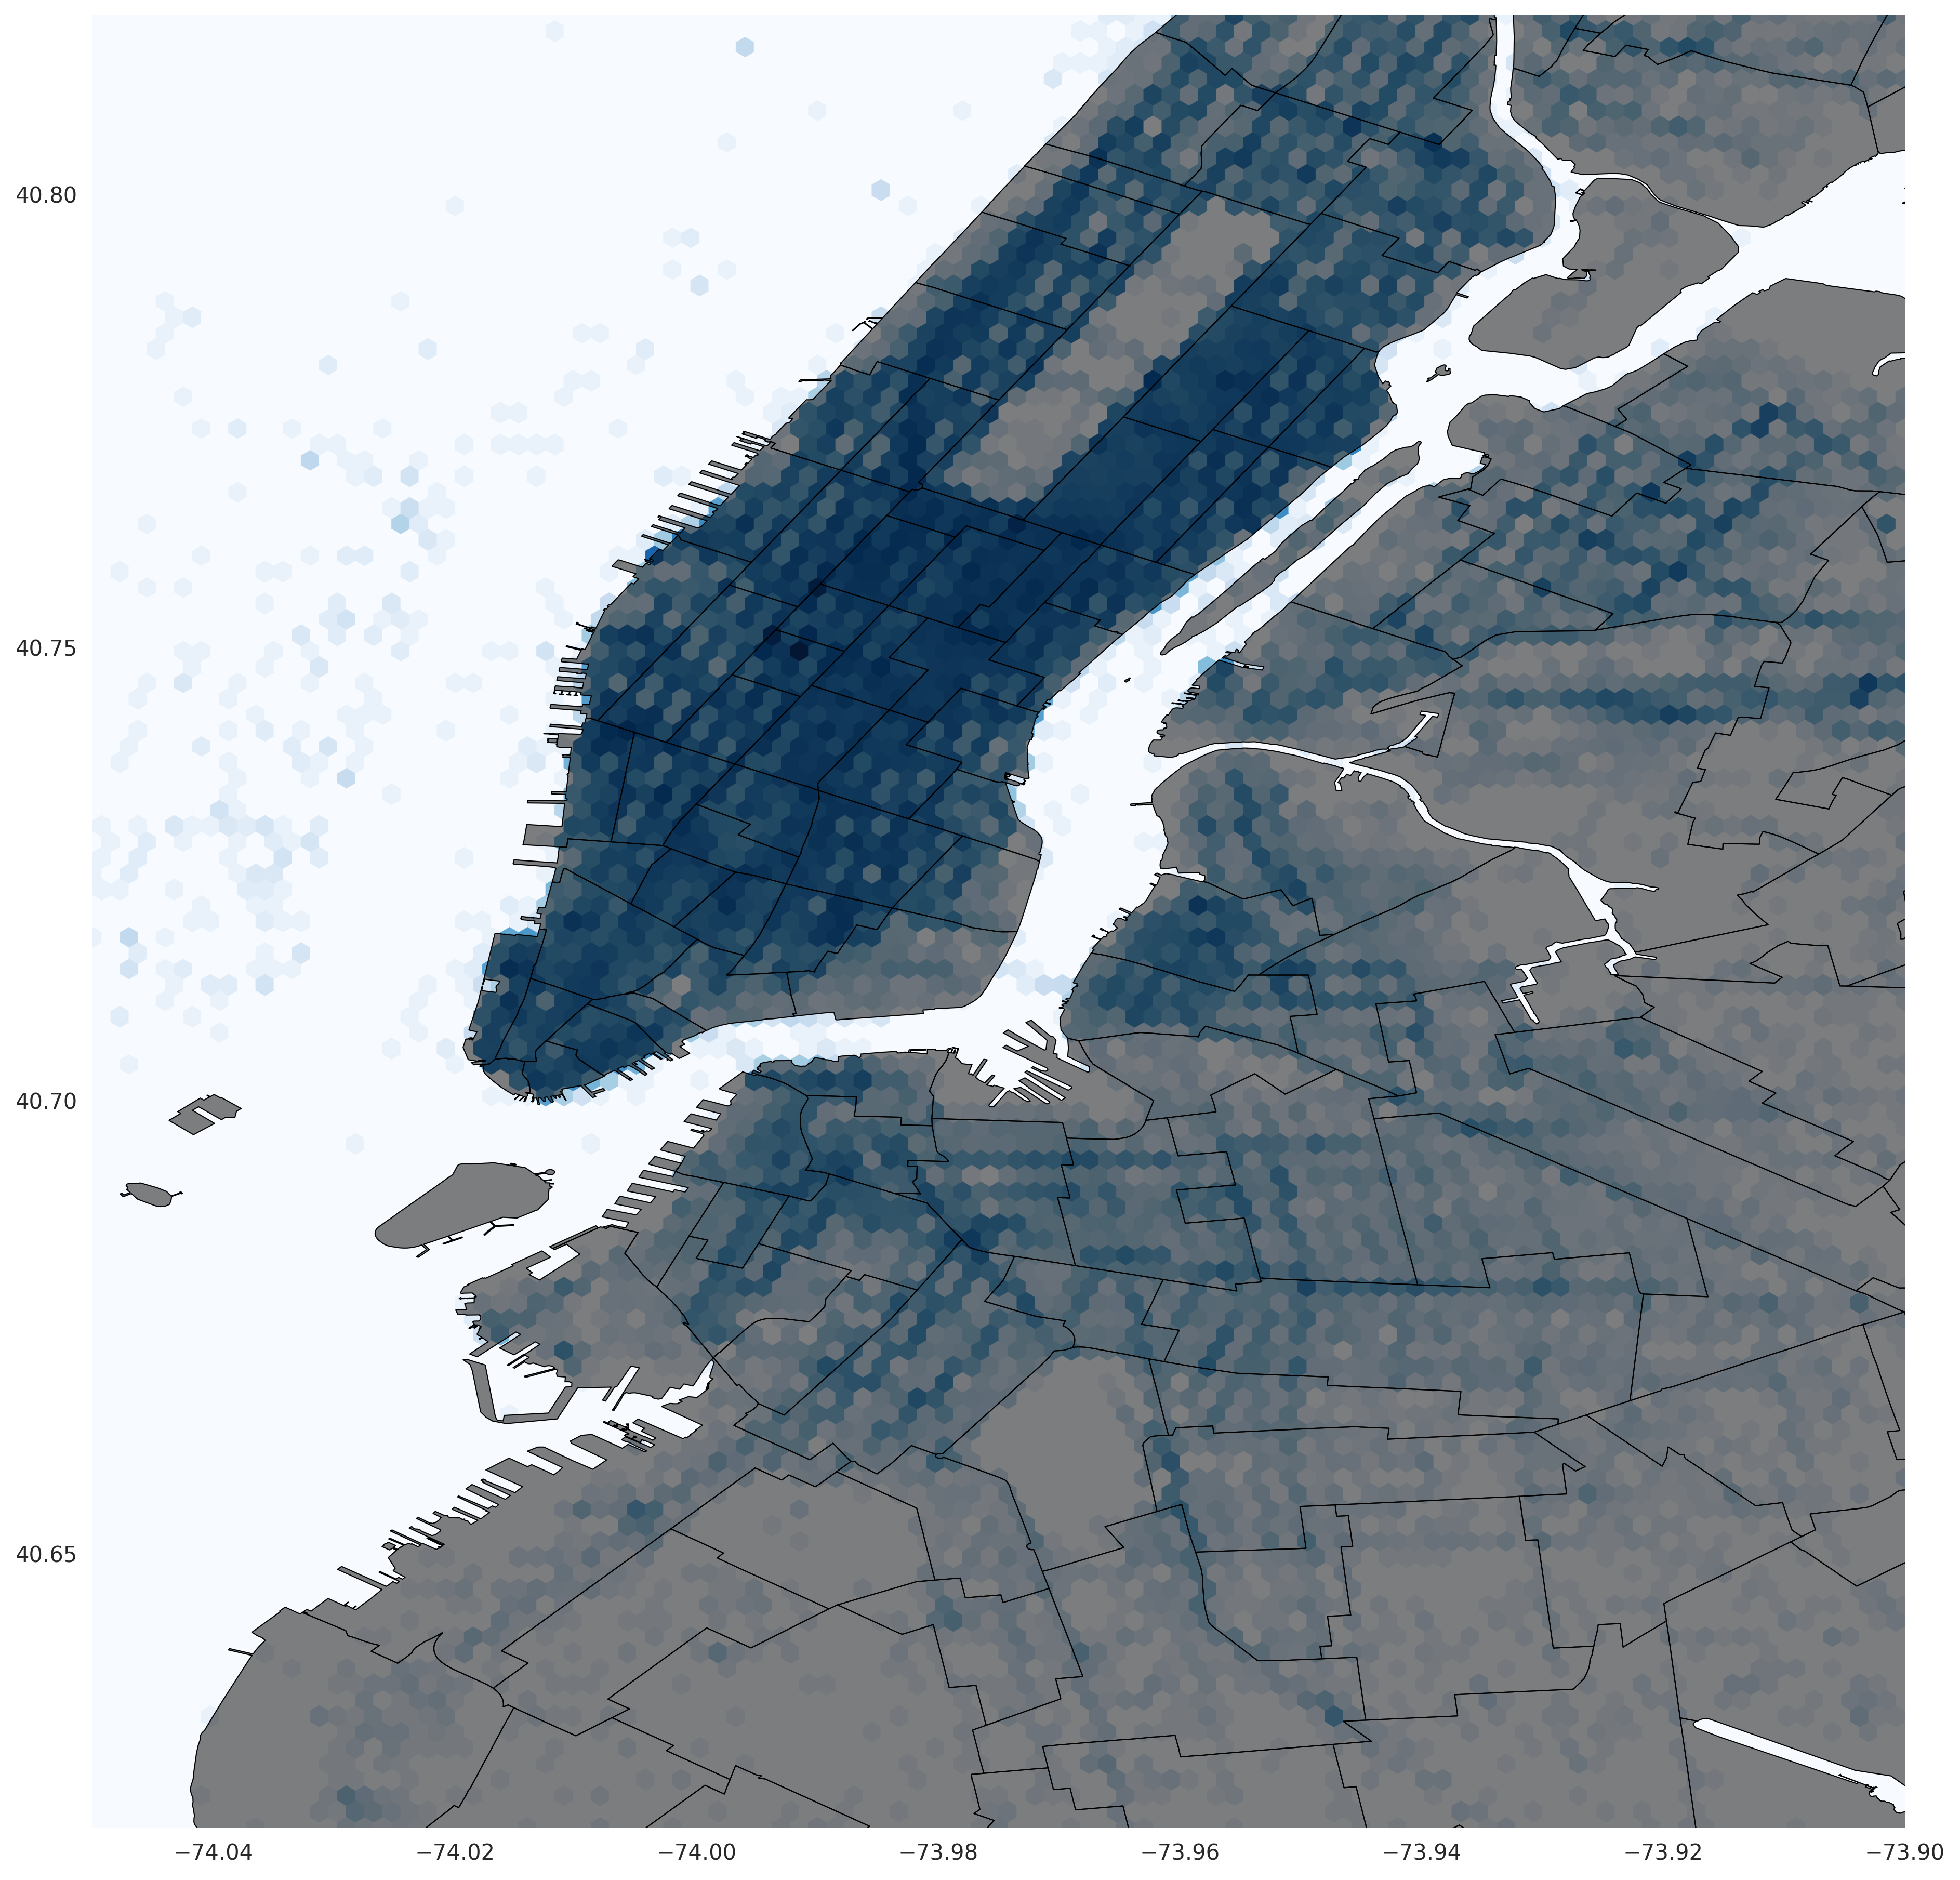

In [28]:
%%time 
plt.hexbin(local_gdf.pickup_longitude, local_gdf.pickup_latitude, bins='log', 
           cmap=plt.cm.Blues,
           extent=(-74.05, -73.9, 40.62, 40.82))
shape_df2.plot(color='k', ax=plt.gca(), linewidth=0.5)
plt.xlim(-74.05, -73.9)
plt.ylim(40.62, 40.82)
plt.gcf().set_size_inches(15, 15)

In [29]:
%%time
k0 = gpd.sjoin(local_gdf, shape_df, how='left', op='within')
k0

CPU times: user 3min 7s, sys: 292 ms, total: 3min 7s
Wall time: 3min 8s


In [30]:
k1 = k0[['index_right', 'LocationID']].groupby('index_right').count()

In [31]:
k1.index = k1.index.astype(int)

In [39]:
z = pd.merge(shape_df, k1, left_index=True, right_index=True, how='left')

In [40]:
z['N'] = z.LocationID_y.rename('N')
z['logN'] = np.log10(z.N)

In [41]:
z.logN.fillna(0)

0      2.008600
1      0.000000
2      1.591065
3      3.648262
4      0.000000
5      0.477121
6      4.106938
7      1.518514
8      0.903090
9      2.315970
10     1.176091
11     2.937518
12     4.099024
13     2.414973
14     0.954243
15     1.505150
16     3.671080
17     2.691965
18     1.204120
19     2.608526
20     1.447158
21     1.716003
22     0.301030
23     3.630428
24     3.811106
25     1.913814
26     0.477121
27     2.453318
28     1.875061
29     0.000000
         ...   
233    4.622421
234    2.596597
235    4.548770
236    4.607101
237    4.324879
238    4.464981
239    1.672098
240    2.509203
241    2.591065
242    3.218798
243    3.711807
244    0.000000
245    4.308351
246    3.331427
247    2.309630
248    4.464251
249    2.482874
250    0.301030
251    1.414973
252    1.568202
253    2.096910
254    4.079217
255    3.840482
256    2.541579
257    2.064458
258    1.690196
259    3.686458
260    3.895533
261    4.175222
262    4.358011
Name: logN, dtype: float

/home/shekhar/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


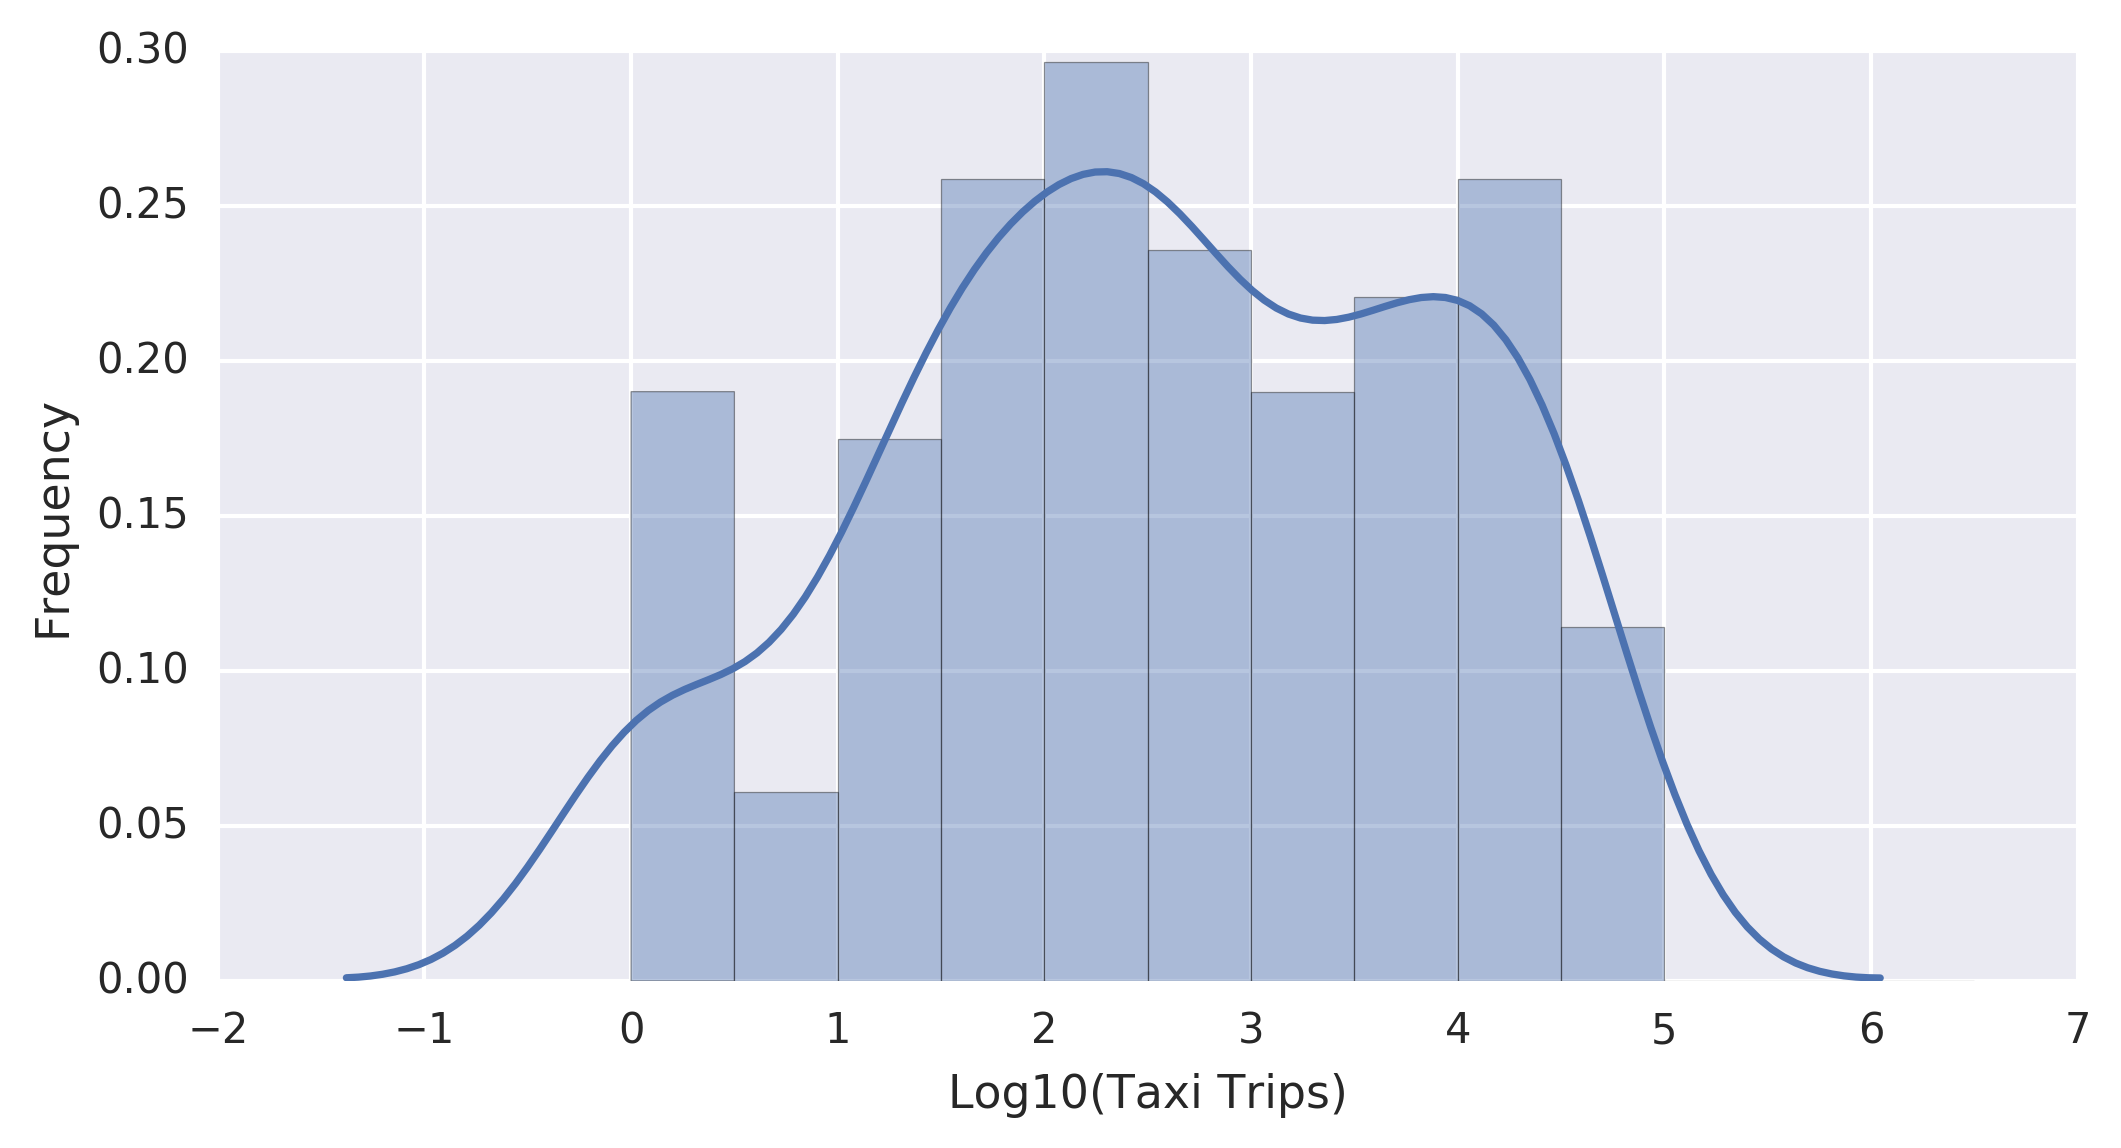

In [42]:
seaborn.distplot(z.logN.fillna(0), bins=np.arange(0, 7., 0.5), norm_hist=True)
# plt.xticks(np.linspace(0, 8, 17));
plt.xlabel("Log10(Taxi Trips)")
plt.ylabel("Frequency")
plt.gcf().set_size_inches(8, 4)

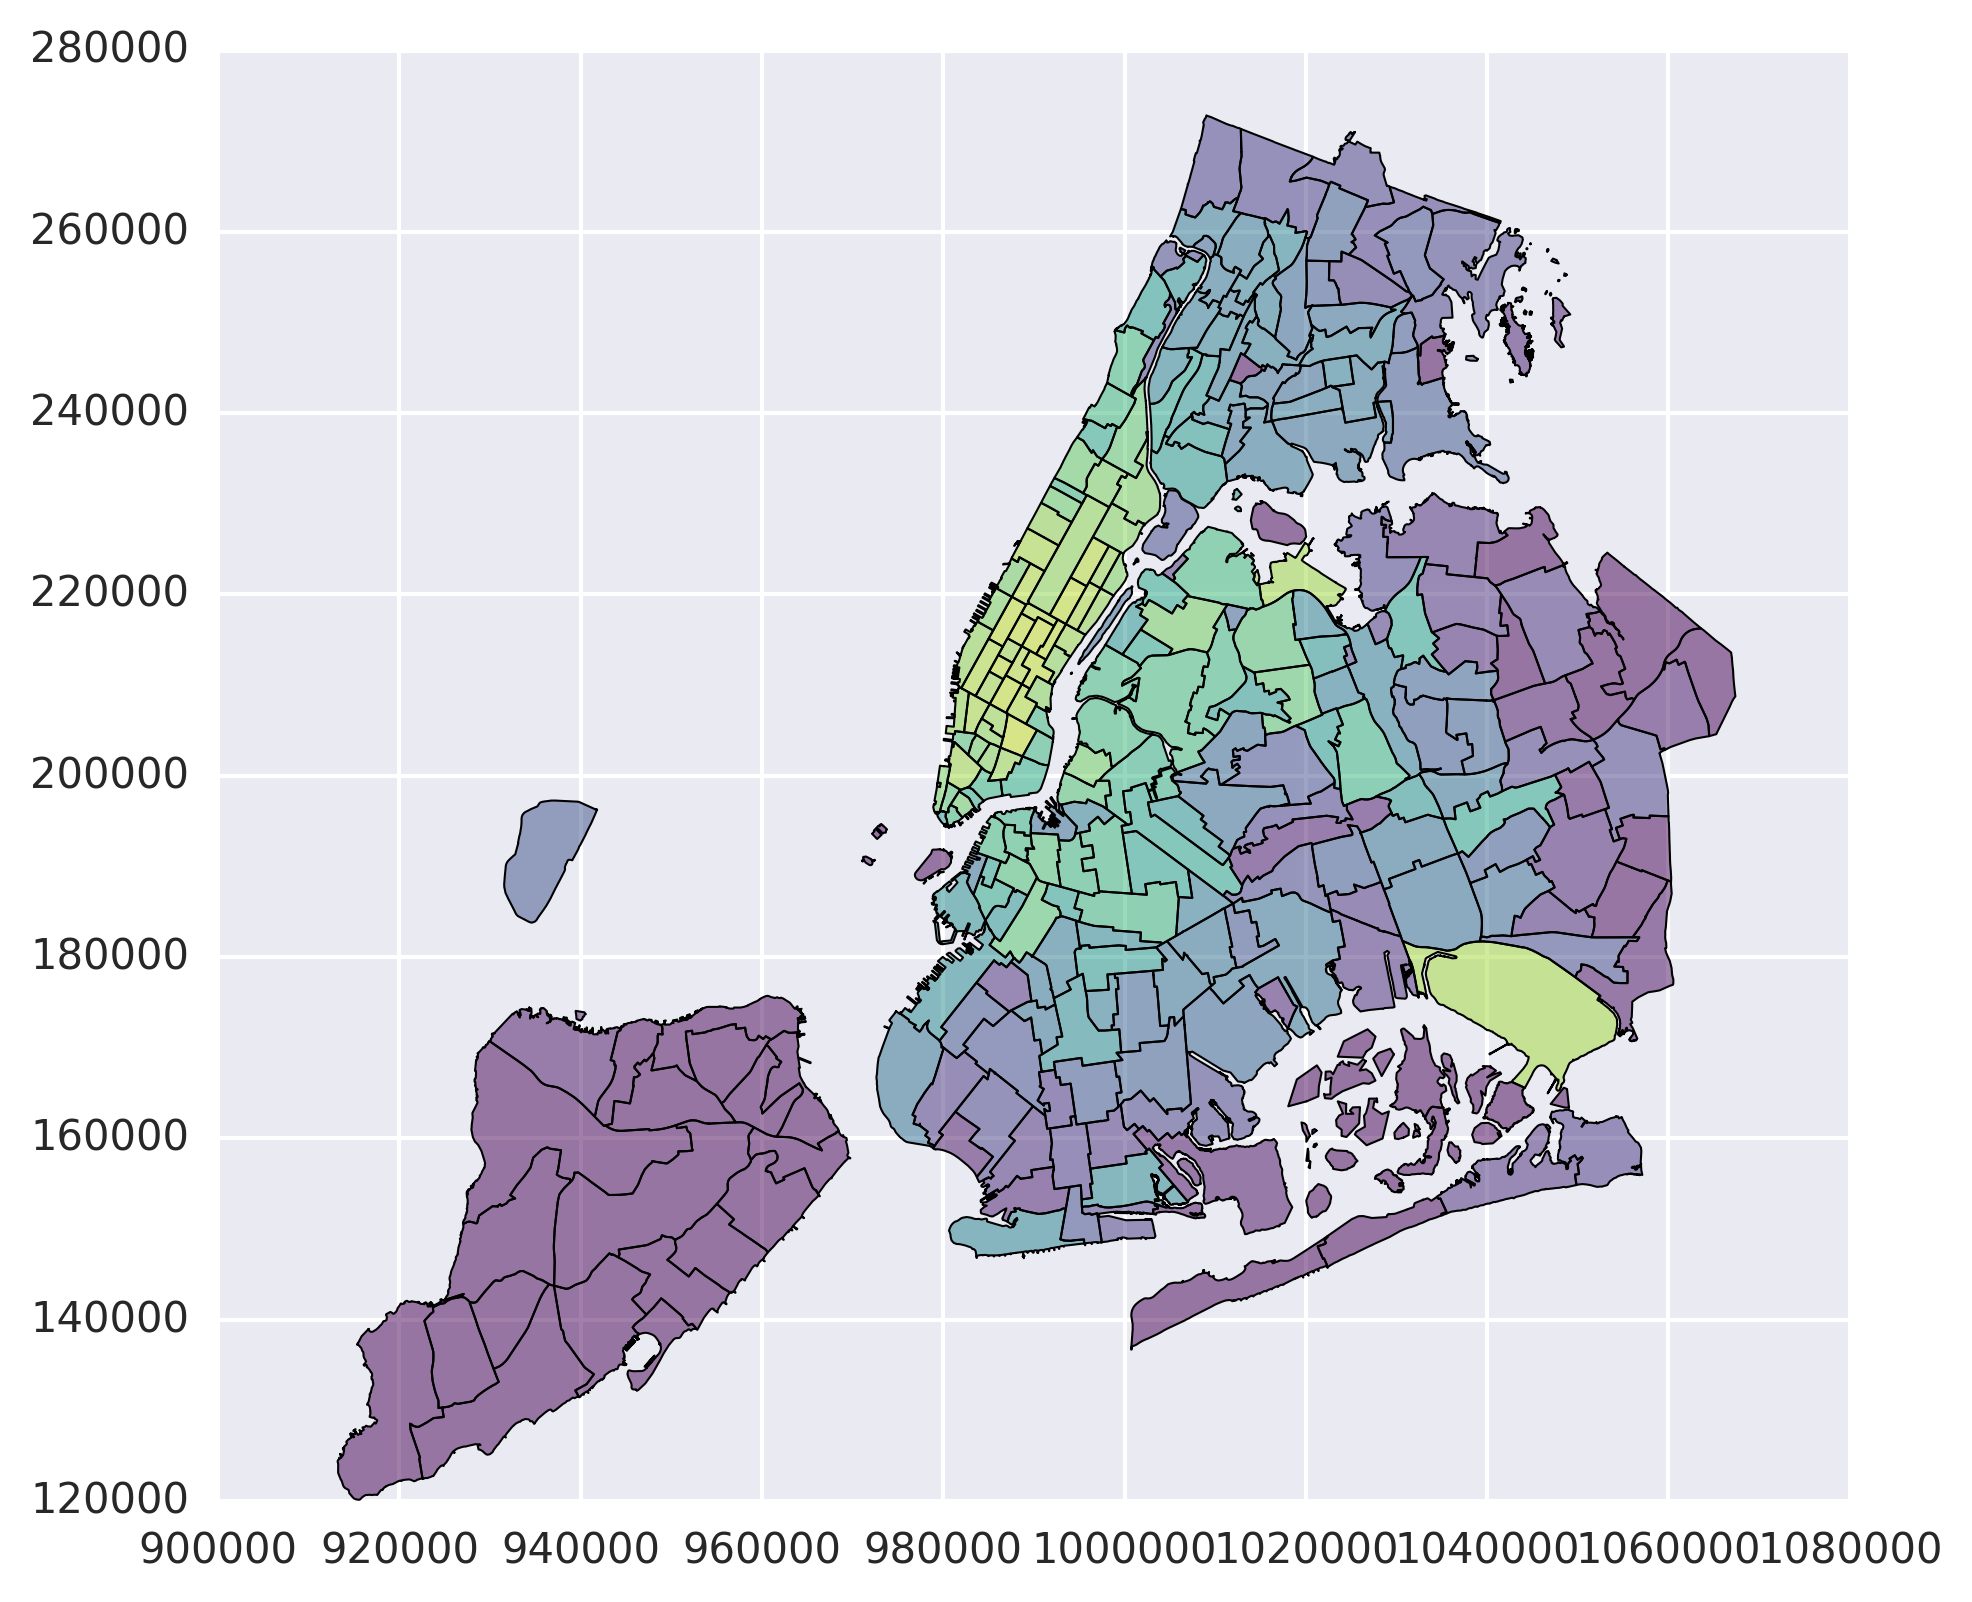

In [43]:
plt.gcf().set_size_inches(12, 9)
z.plot(column='logN', cmap=plt.cm.viridis, linewidth=0.5, vmin=1, vmax=5)
plt.tight_layout()

In [44]:
z = z[(z.borough != 'Staten Island')]
z = z[(z.borough != 'EWR')]

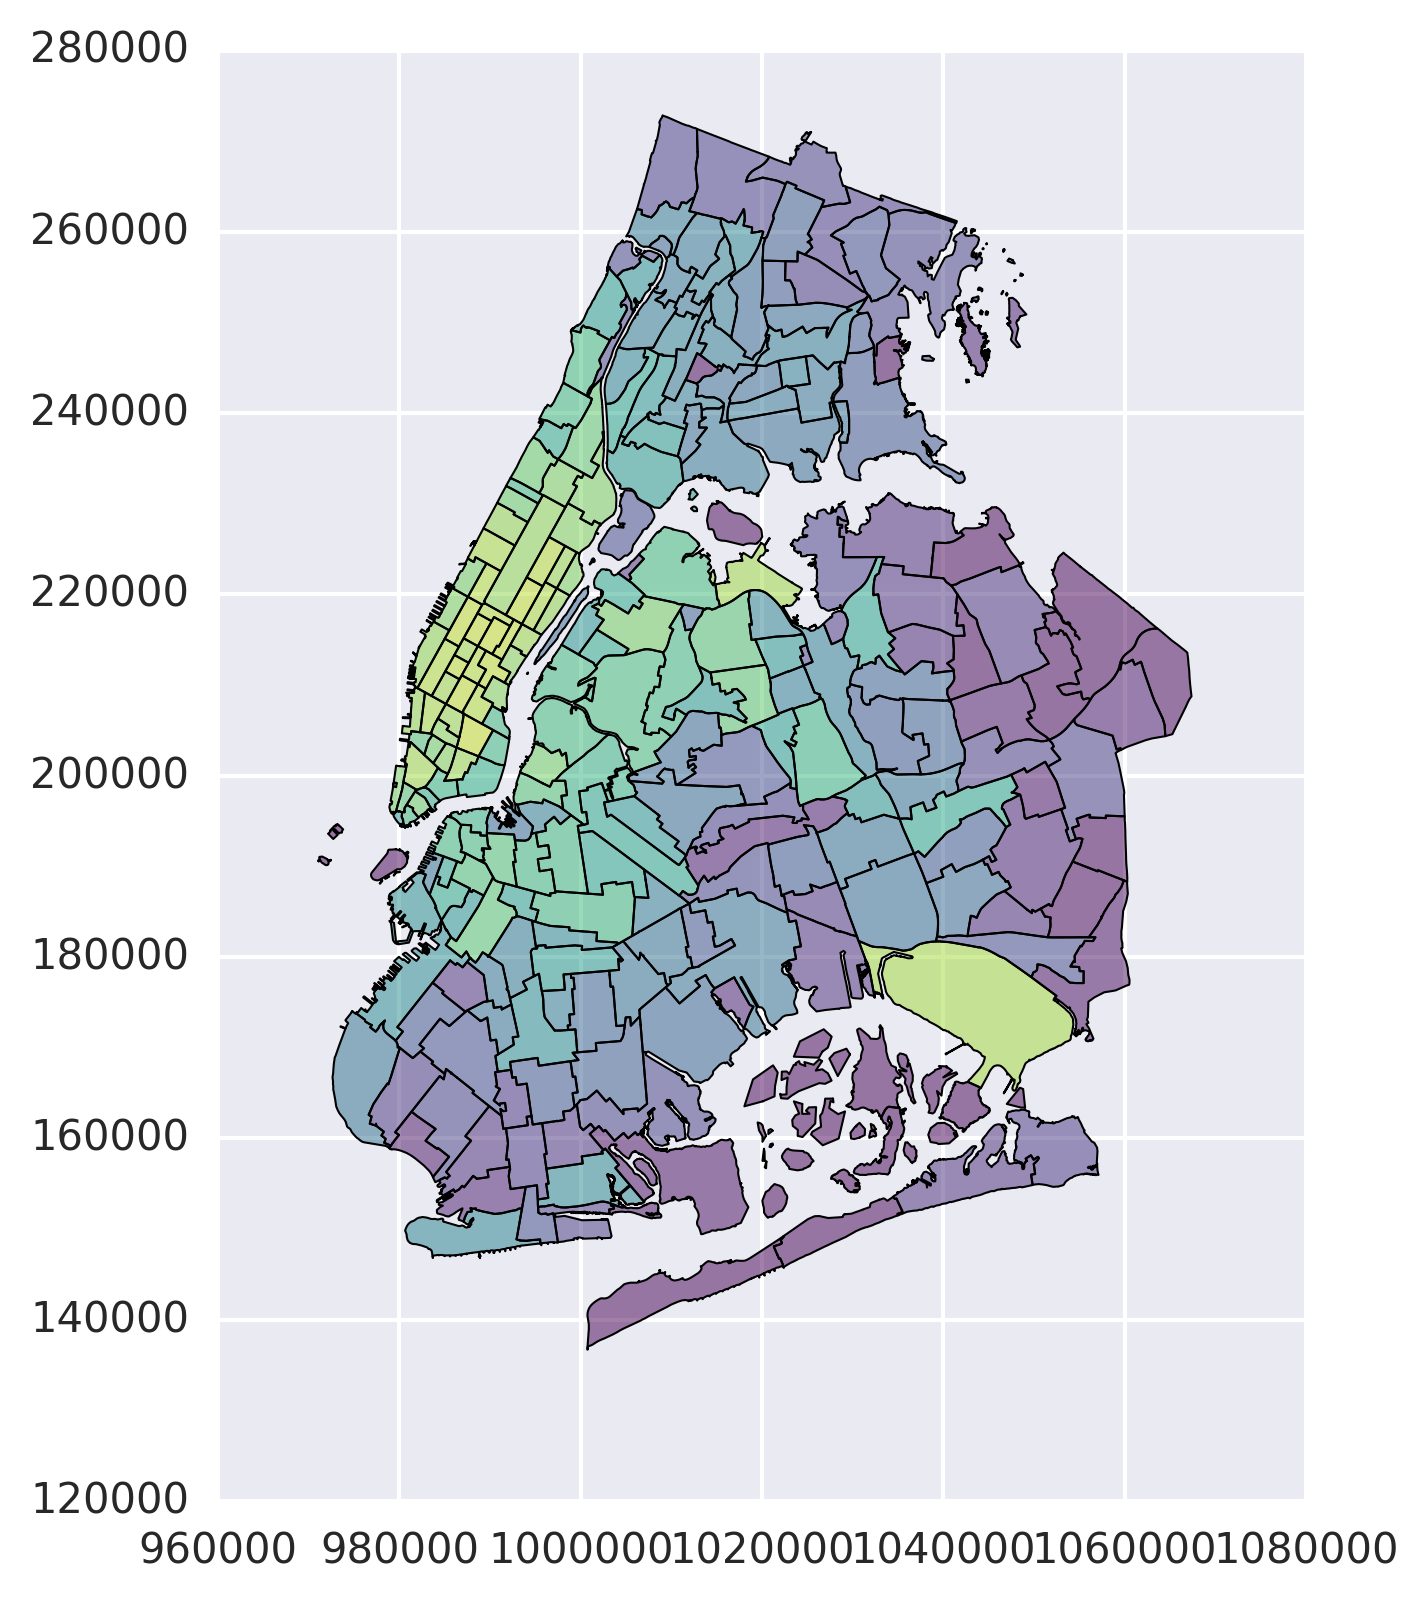

In [45]:
plt.gcf().set_size_inches(12, 9)
z.plot(column='logN', cmap=plt.cm.viridis, linewidth=0.5, vmin=1, vmax=5)
plt.tight_layout()